In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.233765  0.799968  0.180874  0.789702  1.054172 -0.094009 -0.328674   
  1  -0.019449  0.825223 -0.374816  0.690114  0.775299  0.042268 -0.379373   
  2   0.249325  0.384242 -0.789038 -0.806486  0.394610  0.263223  0.166465   
  3   0.270939  0.384046 -0.262450  0.119191 -0.165172 -0.495713 -1.117265   
  4  -0.696041  0.845933 -0.579834  0.440013 -0.330158  0.378251 -0.235033   
  5  -0.757564  0.245455 -0.352083  0.346501  0.336483  1.127177 -0.387543   
  6   0.438660  0.943263 -0.408171  0.153401  0.787287 -0.132474  0.208044   
  7   0.972379  0.666374 -0.508865  0.345859  0.616635  0.298769 -0.491217   
  8  -1.066201  0.739895 -0.274670  0.314449  1.639479  0.986495 -0.627011   
  9   0.494866  0.990924 -0.064813  0.480436  0.733138 -0.486547 -0.953432   
  10  0.676367  0.967746  0.443590  0.056725 -0.293642 -0.063425 -0.322708   
  11  0.287698  1.202737 -0.688457  0.051903  0.426550 -0.788604  0.029616   
  12 -0.005412  1.031001 -0.953894 -0.070568 -0.103442 -0.427245 -0.097555   
  13 -0.553434  1.200922 -0.344016  0.613625  0.547612  0.240994  0.317959   
  14 -0.043314  0.632960  0.010116  0.481978  1.106606  0.448559 -0.208852   
  15  0.720202  1.087768  0.168119  0.385028 -0.189968  0.422127 -0.203014   
  16  0.678038  0.812502 -0.752610  0.129276  0.120517  0.435108  0.134540   
  17  0.193896  1.520307 -0.345362  0.128696  0.569506  1.038845  1.343352   
  18  0.497845  0.869974  0.649004 -0.151763  0.403726 -0.448295 -0.739167   
  19  0.499608  1.233858  0.241225  0.589949  0.584679  0.568282 -0.742166   
  20 -0.381165 -0.162528  0.104673  0.448323 -1.004756 -0.142216  0.173459   
  21 -0.510538  1.234161  0.607894  1.779359  1.503692  1.689136 -0.196833   
  22  0.353392  0.713968  0.112103  1.779104  1.246465  0.167279 -0.574505   
  23  0.215876 -0.123783 -1.332553  0.252945 -0.053924  0.184164 -1.182789   
  24 -0.276792  0.451389 -0.688794 -0.902855  0.888821  0.622991  0.057041   
1 0  -1.081015 -0.240117  0.948734  0.256912  0.202922  0.317700  0.162065   
  1   0.167371  0.694902 -0.113975  0.771407 -0.574622 -0.449799  0.674772   
  2  -0.449572 -0.609902 -0.266843 -0.449882  1.291406  0.330939  0.054434   
  3   0.822252  0.720730  0.913596 -0.865399 -0.755163  0.574304  0.589714   
  4  -0.076600  0.425242 -0.320185 -0.838337 -0.777361 -0.588534 -0.104744   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.231602 -1.413836 -0.212584  ...  0.393706  0.006586 -0.665850   
  1  -0.940688  0.299003 -0.378892  ...  0.014069 -0.969387 -0.874115   
  2   0.230916 -0.090273 -0.129572  ... -0.045126  0.120290  1.098154   
  3  -0.246980  0.814096  0.834342  ... -0.607212  0.055702  0.299861   
  4  -0.536614  0.422551  0.746151  ...  0.511091 -0.135975  0.647968   
  5  -0.023652  0.420745  0.565418  ...  0.046715  0.164683 -0.844203   
  6   0.389075  0.012591  0.922799  ... -1.619159 -1.084025 -1.082247   
  7  -0.203094  0.369133 -0.373443  ...  0.216869 -0.977493  0.553774   
  8   0.372110  0.859041  1.387973  ... -0.049379 -0.431133  0.714929   
  9  -0.310737  0.730663  0.549174  ...  0.256768 -0.616344 -1.418524   
  10  0.427309 -0.309482  0.865728  ...  0.065133 -0.383080 -0.119874   
  11  0.140744  0.215941 -0.421994  ...  0.860718 -0.836562  0.439127   
  12 -0.040653  0.770759 -0.384893  ... -0.026110 -0.264821 -0.834480   
  13 -0.604285  0.316351  0.111642  ...  0.886884  0.331147 -0.448159   
  14  0.109608 -0.002801  0.329303  ... -0.213108 -0.866297 -0.019863   
  15 -0.812622  0.141830 -0.356934  ...  0.410402  0.887412  0.358136   
  16  0.454768  0.660479  0.388507  ... -0.219921 -0.169364 -0.481963   
  17  0.143260  1.160899 -0.556499  ... -0.569393  0.358567  0.416676   
  18 -0.330445 -0.285325  0.020874  ...  0.486216 -0.654538 -0.853760   
  19 -0.524157  0.690943  0.882927  ...  0.151701 -0.572014 -1.583484   
  20 -0.230270 -0.044307  0.156364  ...  0.649145  0.808553 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.063114  0.045286  23.475617  7.239305e-122  0.974356  1.151873


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



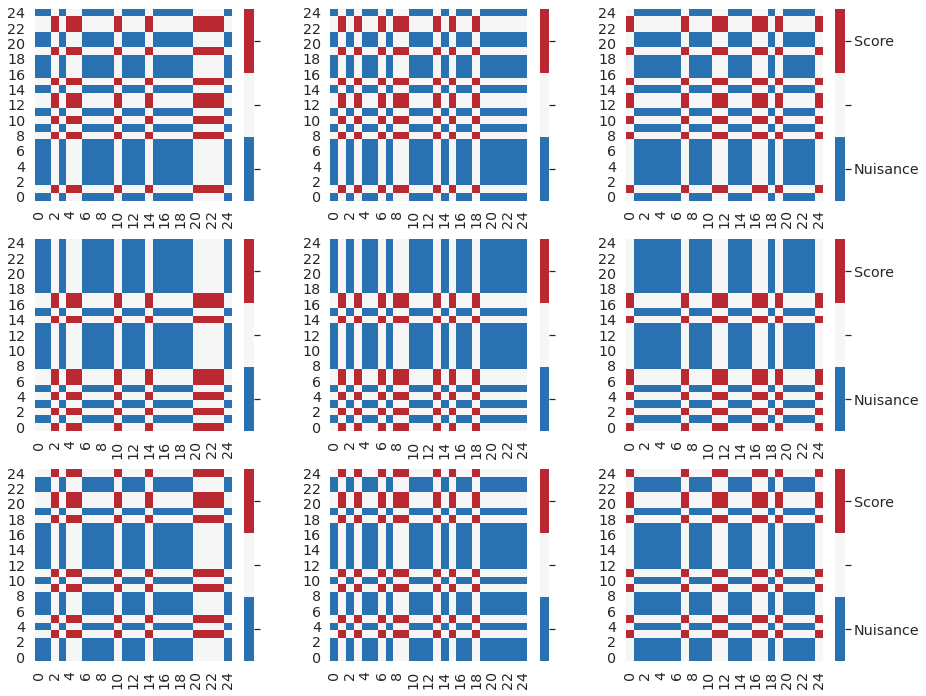

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



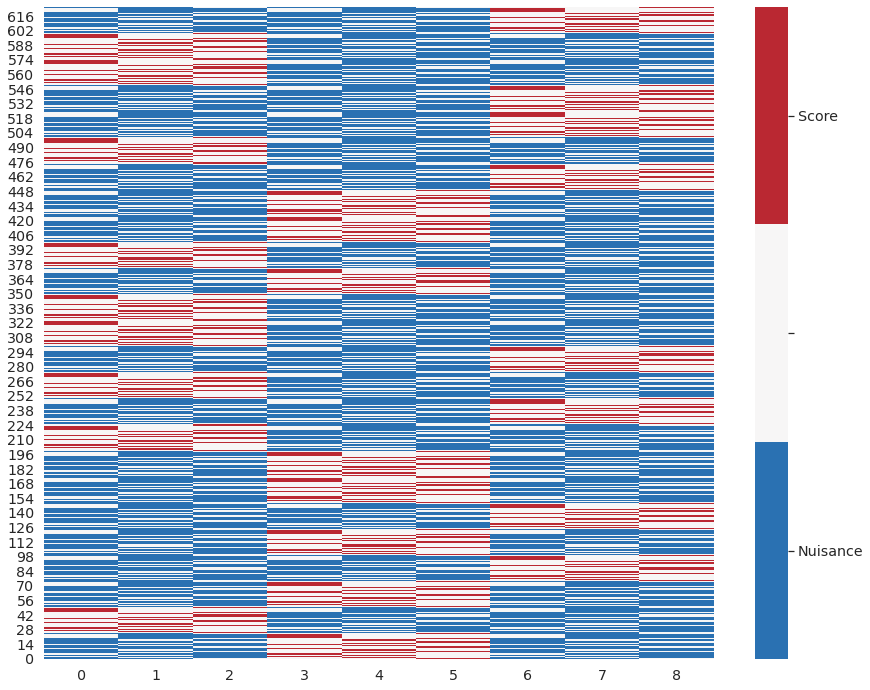

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])